<a href="https://colab.research.google.com/github/SanyaShresta25/Breast-Cancer-Prognostic-Prediction/blob/main/Breast_Cancer_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading dataset...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

✅ Best Parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 150, 'classifier__subsample': 1}

🔎 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96        70
           1       0.95      0.91      0.93        44

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114

✅ Accuracy Score: 0.9473684210526315
🎯 ROC-AUC Score: 0.989935064935065


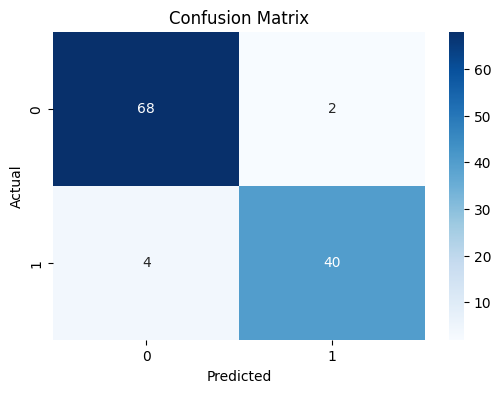

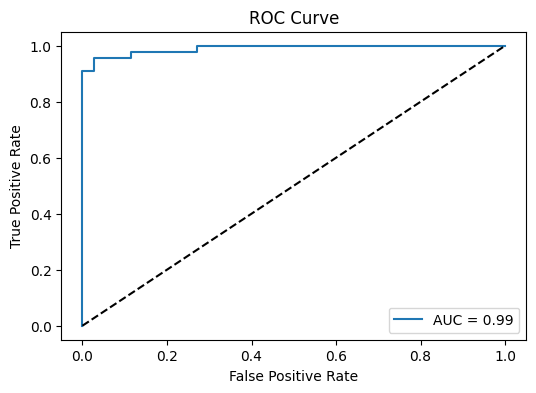

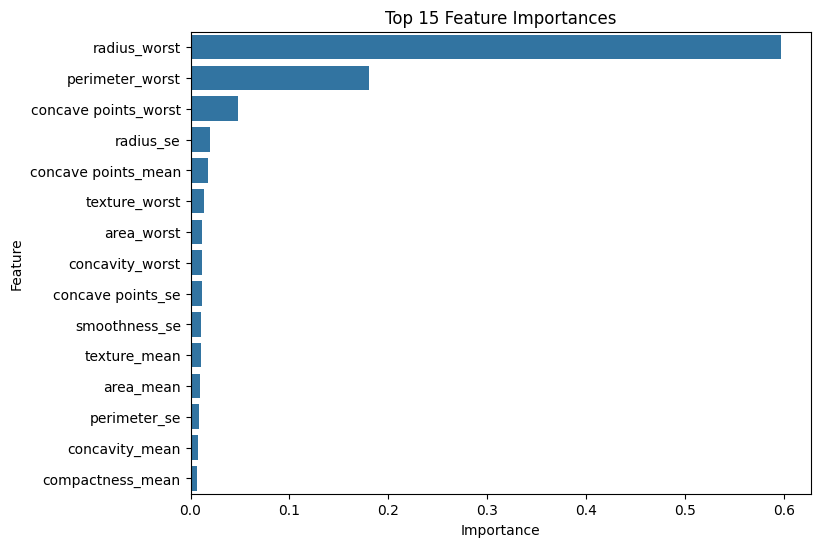


✅ Model saved as 'xgboost_breast_cancer_model.pkl'!
✅ Predictions exported to 'breast_cancer_predictions.csv'!
✅ Grid search results saved as 'grid_search_results.csv'!

🎉 All tasks completed successfully!


In [3]:
# ===========================
# 📦 Install Dependencies
# ===========================
!pip install xgboost scikit-learn pandas matplotlib seaborn joblib

# ===========================
# 📚 Import Libraries
# ===========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import xgboost as xgb

# ===========================
# 📥 Load and Prepare Dataset
# ===========================
print("Loading dataset...")
df = pd.read_csv('/content/breast_cancer.csv')
df.drop(['Unnamed: 32', 'id'], axis=1, inplace=True)

# Split features and target
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# ===========================
# 🧩 Train-Test Split
# ===========================
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=32)

# ===========================
# ⚙️ Preprocessing Pipeline
# ===========================
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
    ]
)

# ===========================
# 🚀 Build XGBoost Model
# ===========================
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', xgb_model)])

# ===========================
# 🔍 Hyperparameter Tuning
# ===========================
param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\n✅ Best Parameters:", grid_search.best_params_)

# ===========================
# 🧩 Evaluate the Model
# ===========================
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\n🔎 Classification Report:\n", classification_report(y_test, y_pred))
print("✅ Accuracy Score:", accuracy_score(y_test, y_pred))
print("🎯 ROC-AUC Score:", roc_auc_score(y_test, y_proba))

# ===========================
# 📊 Confusion Matrix
# ===========================
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ===========================
# 📈 ROC Curve
# ===========================
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# ===========================
# 🎨 Feature Importance
# ===========================
xgb_clf = best_model.named_steps['classifier']
importances = xgb_clf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 Feature Importances')
plt.show()

# ===========================
# 💾 Save Model
# ===========================
joblib.dump(best_model, 'xgboost_breast_cancer_model.pkl')
print("\n✅ Model saved as 'xgboost_breast_cancer_model.pkl'!")

# ===========================
# 📁 Export Predictions
# ===========================
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predictions_df.to_csv('breast_cancer_predictions.csv', index=False)
print("✅ Predictions exported to 'breast_cancer_predictions.csv'!")

# ===========================
# 📝 Export Grid Search Results
# ===========================
grid_results = pd.DataFrame(grid_search.cv_results_)
grid_results.to_csv('grid_search_results.csv', index=False)
print("✅ Grid search results saved as 'grid_search_results.csv'!")

# ===========================
# 🏁 DONE!
# ===========================
print("\n🎉 All tasks completed successfully!")
